# Customer Segmentation Exploratory Analysis

## Initial Data Exploration

In [25]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/raw_data/customer_data.csv')

# Show the first few rows of the data
df.head()


,CustomerID,Age,Income,SpendingScore
0,1,51,57003,33
1,2,41,63273,53
2,3,62,57522,71
3,4,52,57981,96
4,5,32,34912,89


Here we can see the first few rows of the dataset, which includes features such as Age, Income, and Spending Score. We will look at some summary statistics next

In [26]:
# Summary statistics
df.describe()

,CustomerID,Age,Income,SpendingScore
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,40.774000,58123.500000,50.471000
std,288.819436,13.322929,22899.366364,29.124103
min,1.000000,18.000000,20378.000000,1.000000
25%,250.750000,29.750000,38018.000000,25.000000
50%,500.500000,41.000000,57966.500000,50.000000
75%,750.250000,52.000000,77503.250000,77.000000
max,1000.000000,64.000000,99991.000000,99.000000


## Feature Selection Rationale

We are considering the following features for our clustering model:

- Age: Could indicate different purchasing behaviors at different life stages.
- Income: Higher income could mean more spending or different types of spending.
- Spending Score: A measure of the customer's spending behavior.

## Trial Runs of Different Clustering Methods

In [27]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

# Select features for clustering
X = df[['Age', 'Income', 'SpendingScore']]

# KMeans
kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(X)

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_labels = agg_clustering.fit_predict(X)


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Tuning Hyperparameters

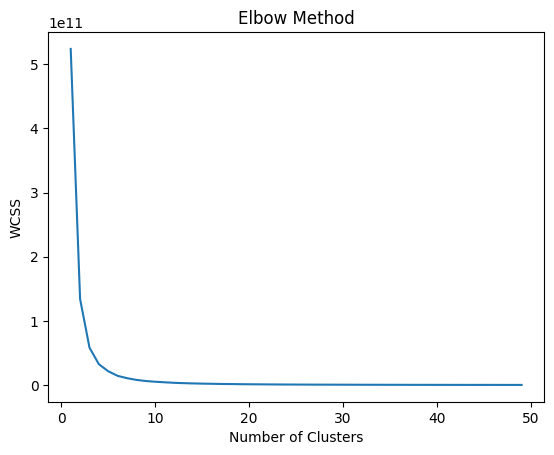

In [28]:
# Using Elbow Method to find an initial guess for the number of cluseters
wcss = []
for i in range(1, 50):  # 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 50), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [29]:
# Using the Silhouette Score method for futher validation
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2, 50):  
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_
    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.6202534187233522)
For n_clusters = 3, silhouette score is 0.5942060567713843)
For n_clusters = 4, silhouette score is 0.5809595386671894)
For n_clusters = 5, silhouette score is 0.5618585761206923)
For n_clusters = 6, silhouette score is 0.564060316943909)
For n_clusters = 7, silhouette score is 0.5578801096281261)
For n_clusters = 8, silhouette score is 0.5597415411917839)
For n_clusters = 9, silhouette score is 0.5557123876543416)
For n_clusters = 10, silhouette score is 0.5533637456527033)
For n_clusters = 11, silhouette score is 0.5507736697930534)
For n_clusters = 12, silhouette score is 0.554019100620447)
For n_clusters = 13, silhouette score is 0.5526246182534362)
For n_clusters = 14, silhouette score is 0.5526089390943185)
For n_clusters = 15, silhouette score is 0.5522516521256953)
For n_clusters = 16, silhouette score is 0.553478690056719)
For n_clusters = 17, silhouette score is 0.549198411262689)
For n_clusters = 18, silhouette scor

After testing both methods I have decided to use the Elbow Method, as in this case it could be more intuitive and computationally efficient.

Based on the elbow method, it appears that X clusters would be optimal.

## Visualizing the Clusters

In [30]:
# Using seaborn for 2D scatter plots
import joblib
import seaborn as sns
# Load the K-means model
kmeans_model = joblib.load('../clustering_algorithms/kmeans_model.pkl')
# Load the original data with cluster labels
df = pd.read_csv('../data/processed_data/segmented_customers_with_clusters.csv')

sns.scatterplot(x='Age', y='Income', hue='Cluster', data=df, palette='viridis', alpha=0.6)
plt.title('Age vs Income')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../clustering_algorithms/kmeans_model.pkl'

## Explanation and Interpretation of the Clusters